In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/mva/dlir/src


# Imports

In [3]:
from utils import *
from params import *

In [4]:
from metric import *

In [5]:
from dcgan import *
from data import *

In [6]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

# Initialization

In [7]:
begin = time.time()
seed_everything(seed)

## Load Data

In [8]:
print('Number of dog images :', len(IMAGES))

Number of dog images : 20579


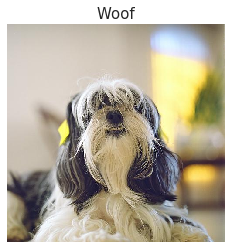

In [9]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.axis(False)
plt.show()

## Seeding

# Dataset

In [10]:
%%time
dataset = DogDataset(DATA_PATH, base_transforms, additional_transforms)

CPU times: user 24.9 s, sys: 1.1 s, total: 26 s
Wall time: 26 s


In [11]:
nb_classes = len(dataset.classes)
print(f'Number of dog breeds : {nb_classes}')

Number of dog breeds : 120


In [12]:
nb_dogs = len(dataset)
print(f'Number of dog: {nb_dogs}')

Number of dog: 22125


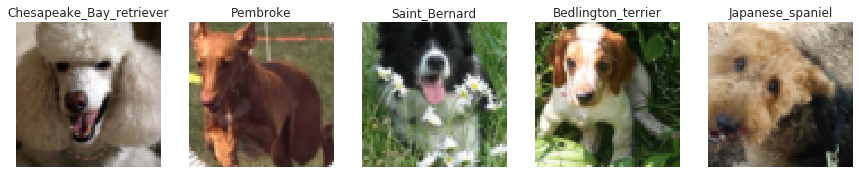

In [16]:
n = 5
plt.figure(figsize=(15, 3))
for idx, i in enumerate(np.random.choice(len(dataset), n)):
    plt.subplot(1, n, idx + 1)
    img, breed = dataset[i]
    plt.imshow(img)
    plt.axis(False)
    
    plt.title(dataset.classes[breed])
plt.show()

# Models

In [13]:
gen = DCGanGenerator().cuda()

# Tools

## Generate

In [14]:
def generate(generator, noise=None, races=None, n=5, n_plot=0, latent_dim=128):
    if noise is None:
        noise = torch.cuda.FloatTensor(n, latent_dim, 1, 1).normal_(0, 1)
    if races is None:
        races = torch.from_numpy(np.random.randint(0, nb_classes, size=n)).long().cuda()
        
    generated_images = generator(noise, races).add(1).div(2)
    images = generated_images.cpu().clone().detach().numpy().transpose(0, 2, 3, 1)
    
    if n_plot:
        plt.figure(figsize=(15, 3 * n_plot//5))
        for i in range(n_plot):
            plt.subplot(n_plot//5, 5, i+1)
            plt.imshow(images[i])
            plt.axis('off')
        plt.show()
    
    return generated_images

## Evaluation

In [15]:
fid = tmp_eval(gen.cuda(), n_images=100)

## Fit

In [24]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
from torch.optim.lr_scheduler import *

In [25]:
def fit(discriminator, generator, dataset, 
        latent_dim=128, epochs=100, batch_size=32, 
        lr_d=1e-3, lr_g=1e-3, scheduler=False, n_critic=1,
        real_label=0.9, fake_label=0, class_loss_weight=1., class_epochs=100,
        seed=2019, verbose=1, verbose_mifid=50):
    
    seed_everything(seed)
    fixed_noise = torch.cuda.FloatTensor(5, latent_dim, 1, 1).normal_(0, 1).cuda()
    fixed_races = torch.from_numpy(np.random.randint(0, nb_classes, size=5)).long().cuda()
    infos = {"discriminator_loss": [], "generator_loss": [], 'generator_lr': [], 'discriminator_lr': []}
    
#     clip_value = 1.0
#     for p in generator.parameters():
#         p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
#     for p in discriminator.parameters():
#         p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    scheduler_d = CosineAnnealingLR(optimizer_d, T_max=epochs, eta_min=1e-5)
    scheduler_g = CosineAnnealingLR(optimizer_g, T_max=epochs, eta_min=1e-5)
    
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    loss_classes_fn = nn.CrossEntropyLoss(reduction='sum')
    loss_ft_matching = nn.MSELoss(reduction='sum')
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

    for epoch in range(epochs):
        start_time = time.time()  
        d_loss = 0
        g_loss = 0
        
        class_loss = 0
        class_loss_weight_ = max(class_loss_weight * (class_epochs - epoch) / class_epochs, 0)
        compute_class_loss = class_loss_weight_ > 0
        
        if scheduler:
            scheduler_d.step()
            scheduler_g.step()
            lr_d = np.mean([param_group['lr'] for param_group in optimizer_d.param_groups])
            lr_g = np.mean([param_group['lr'] for param_group in optimizer_g.param_groups])
            
        for x, y in loader:
            t0 = time.time()

            ########   Update discriminator ########
            
            for i in range(n_critic):
                discriminator.zero_grad()
                batch_size = x.size(0)
                labels = torch.full((batch_size, 1), real_label).cuda()

                output, out_classes, _ = discriminator(x.cuda(), y.cuda(), return_classes=compute_class_loss)

                if compute_class_loss:
                    loss_class = loss_classes_fn(out_classes, y.cuda())
                    loss_real = loss_fn(output, labels) + class_loss_weight_ * loss_class
                    class_loss += loss_class.item() / (len(dataset) * n_critic)
                else:
                    loss_real = loss_fn(output, labels)
                    
                loss_real.backward()

                noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
                fake_races = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
                fake = generator(noise, fake_races)

                labels.fill_(fake_label)
                output, _, _ = discriminator(fake.detach(), fake_races)

                loss_fake = loss_fn(output, labels)
                loss_fake.backward()

                loss_d = loss_real + loss_fake
                d_loss += loss_d.item() / (len(dataset) * n_critic) 
                optimizer_d.step()
                
                ## Relativistic Standard Loss ##
#                 labels.fill_(1.)
#                 loss_d = loss_fn(output - output_fake, labels)
#                 loss_d.backward()

            
            ########   Update Generator with feature matching ########
            
            generator.zero_grad()
            labels.fill_(real_label)
            
            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_races = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
    
            _, _, features_real = discriminator(x.cuda(), y.cuda())
            output_fake, _, features_fake = discriminator(fake, fake_races)
            
            features_real = torch.mean(features_real, 0)
            features_fake = torch.mean(features_fake, 0)
            
            loss_g = loss_ft_matching(features_real, features_fake) # + loss_fn(output_fake, labels)
            loss_g.backward()
            
            g_loss += loss_g.item() / len(dataset)
            optimizer_g.step()   
        
        d_loss -= class_loss_weight_ * class_loss
        elapsed_time = time.time() - start_time
        
        infos['discriminator_loss'].append(d_loss)
        infos['generator_loss'].append(g_loss)
        infos['generator_lr'].append(lr_g)
        infos['discriminator_lr'].append(lr_d)
        
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(f'Epoch {epoch+1}/{epochs}     lr_g={lr_g:.1e}     lr_d={lr_d:.1e}', end='     ')
            print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')
            if (epoch + 1) % verbose_mifid == 0:
                score = tmp_eval(generator, n_images=10000, latent_dim=latent_dim)
                seed_everything(seed + epoch)
                print(f'\n -> MiFID at epoch {epoch+1} is {score:.3f} \n')
            elif (epoch + 1) % 10 == 0:
                generate(generator, noise=fixed_noise, races=fixed_races, n=5, n_plot=5, latent_dim=latent_dim)
                
    return infos

# Training

In [26]:
seed_everything(seed)

In [27]:
latent_dim = 256

In [28]:
embed_dim_g = 8
embed_dim_d = 8

ngf = 128
ndf = 128
nb_ft = 64

discriminator = DCGanDiscriminator(ndf=ndf, nb_classes=nb_classes, embedding_dim=embed_dim_d, nb_ft=nb_ft).cuda()
generator = DCGanGenerator(latent_dim=latent_dim, ngf=ngf, nb_classes=nb_classes, embedding_dim=embed_dim_g).cuda()

discriminator.apply(weights_init)
generator.apply(weights_init)

print('Using DCGan')

Using DCGan


In [29]:
batch_size = 64
lr_g = 1e-3  # tweak !
lr_d = 5e-4  # tweak !

scheduler = False
epochs = 200
n_critic = 1

class_loss_weight = 0 #0.5
class_epochs = 100

Epoch 1/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.669     gen_loss=6.645     t=53s
Epoch 2/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.113     gen_loss=2.411     t=55s
Epoch 3/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.112     gen_loss=2.775     t=55s
Epoch 4/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.191     gen_loss=2.241     t=56s
Epoch 5/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.225     gen_loss=2.029     t=56s
Epoch 6/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.207     gen_loss=2.792     t=56s
Epoch 7/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.224     gen_loss=2.346     t=56s
Epoch 8/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.239     gen_loss=2.581     t=56s
Epoch 9/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.251     gen_loss=2.759     t=56s
Epoch 10/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.254     gen_loss=3.088     t=56s


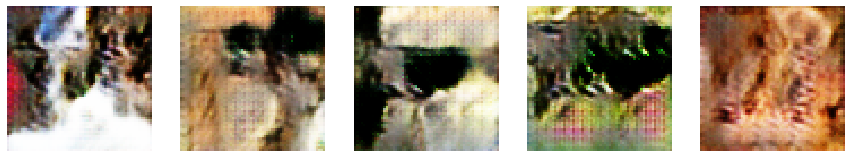

Epoch 11/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.259     gen_loss=3.309     t=56s
Epoch 12/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.267     gen_loss=3.450     t=56s
Epoch 13/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.276     gen_loss=3.499     t=56s
Epoch 14/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.284     gen_loss=3.506     t=56s
Epoch 15/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.292     gen_loss=3.443     t=56s
Epoch 16/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.277     gen_loss=4.259     t=56s
Epoch 17/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.278     gen_loss=4.755     t=56s
Epoch 18/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.264     gen_loss=5.477     t=56s
Epoch 19/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.258     gen_loss=6.027     t=56s
Epoch 20/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.247     gen_loss=6.655     t=56s


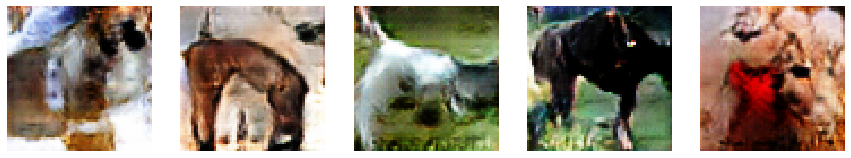

Epoch 21/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.217     gen_loss=8.043     t=56s
Epoch 22/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.206     gen_loss=8.528     t=56s
Epoch 23/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.179     gen_loss=9.512     t=56s
Epoch 24/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.134     gen_loss=10.993     t=56s
Epoch 25/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.109     gen_loss=11.448     t=56s
Epoch 26/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.065     gen_loss=12.688     t=56s
Epoch 27/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.039     gen_loss=13.060     t=56s
Epoch 28/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.006     gen_loss=13.755     t=56s
Epoch 29/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.987     gen_loss=13.650     t=56s
Epoch 30/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.922     gen_loss=15.088     t=56s


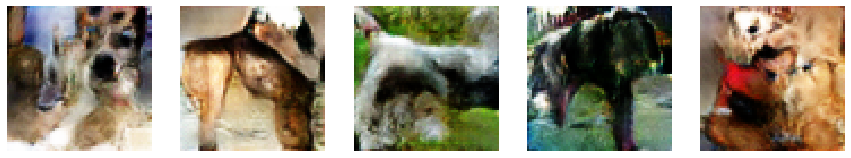

Epoch 31/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.884     gen_loss=15.884     t=56s
Epoch 32/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.912     gen_loss=15.481     t=56s
Epoch 33/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.843     gen_loss=17.037     t=56s
Epoch 34/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.814     gen_loss=17.394     t=56s
Epoch 35/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.867     gen_loss=17.250     t=56s
Epoch 36/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.804     gen_loss=18.789     t=56s
Epoch 37/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.769     gen_loss=19.935     t=56s
Epoch 38/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.764     gen_loss=20.007     t=56s
Epoch 39/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.762     gen_loss=19.826     t=56s
Epoch 40/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.727     gen_loss=21.329     t=56s


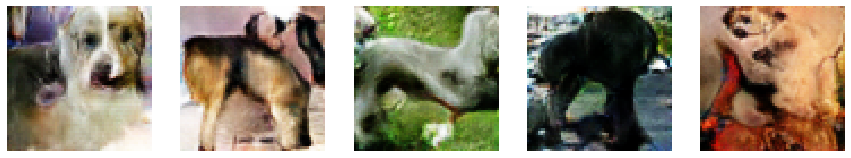

Epoch 41/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.736     gen_loss=20.877     t=56s
Epoch 42/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.732     gen_loss=21.398     t=56s
Epoch 43/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.752     gen_loss=22.028     t=56s
Epoch 44/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.682     gen_loss=23.712     t=56s
Epoch 45/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.715     gen_loss=23.141     t=56s
Epoch 46/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.643     gen_loss=24.149     t=56s
Epoch 47/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.663     gen_loss=24.881     t=56s
Epoch 48/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.722     gen_loss=25.175     t=56s
Epoch 49/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.620     gen_loss=26.625     t=56s
Epoch 50/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.716     gen_loss=25.236     t=56s

 -> MiFID at epoch 50 is 85.1

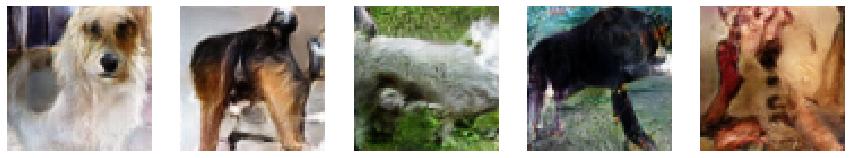

Epoch 61/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.573     gen_loss=34.056     t=56s
Epoch 62/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.596     gen_loss=35.410     t=56s
Epoch 63/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.612     gen_loss=35.092     t=56s
Epoch 64/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.564     gen_loss=36.052     t=56s
Epoch 65/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.558     gen_loss=36.575     t=56s
Epoch 66/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.599     gen_loss=36.762     t=56s
Epoch 67/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.615     gen_loss=35.567     t=56s
Epoch 68/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.577     gen_loss=35.651     t=56s
Epoch 69/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.513     gen_loss=36.880     t=56s
Epoch 70/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.535     gen_loss=37.768     t=56s


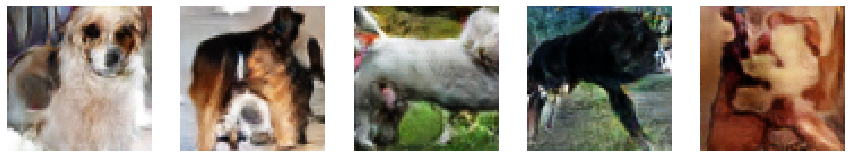

Epoch 71/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.550     gen_loss=38.985     t=56s
Epoch 72/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.570     gen_loss=38.435     t=56s
Epoch 73/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.605     gen_loss=39.805     t=56s
Epoch 74/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.512     gen_loss=39.888     t=56s
Epoch 75/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.575     gen_loss=38.884     t=56s
Epoch 76/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.550     gen_loss=41.185     t=56s
Epoch 77/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.509     gen_loss=40.601     t=56s
Epoch 78/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.516     gen_loss=42.077     t=56s
Epoch 79/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.507     gen_loss=42.408     t=56s
Epoch 80/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.507     gen_loss=43.364     t=56s


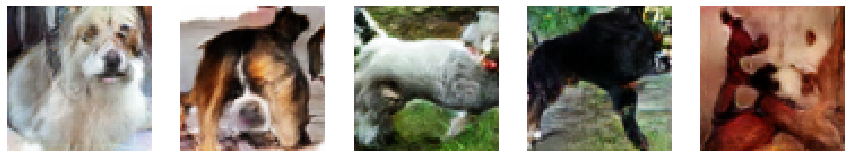

Epoch 81/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.636     gen_loss=42.500     t=56s
Epoch 82/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.729     gen_loss=34.963     t=56s
Epoch 83/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.541     gen_loss=44.586     t=56s
Epoch 84/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.500     gen_loss=45.558     t=56s
Epoch 85/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.503     gen_loss=46.337     t=56s
Epoch 86/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.556     gen_loss=47.028     t=56s
Epoch 87/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.517     gen_loss=47.982     t=56s
Epoch 88/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.499     gen_loss=48.533     t=56s
Epoch 89/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.490     gen_loss=48.710     t=56s
Epoch 90/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.579     gen_loss=47.303     t=56s


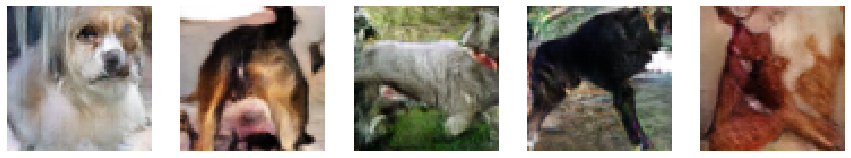

Epoch 91/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.488     gen_loss=47.713     t=56s
Epoch 92/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.477     gen_loss=48.559     t=56s
Epoch 93/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.473     gen_loss=49.226     t=56s
Epoch 94/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.531     gen_loss=50.461     t=56s
Epoch 95/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.470     gen_loss=49.236     t=56s
Epoch 96/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.471     gen_loss=50.820     t=56s
Epoch 97/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.474     gen_loss=51.406     t=56s
Epoch 98/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.487     gen_loss=53.436     t=56s
Epoch 99/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.529     gen_loss=54.934     t=56s
Epoch 100/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.483     gen_loss=53.521     t=56s

 -> MiFID at epoch 100 is 70

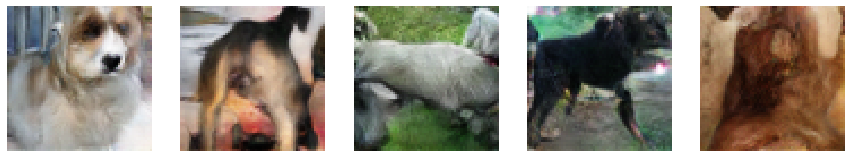

Epoch 111/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.468     gen_loss=60.244     t=56s
Epoch 112/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.471     gen_loss=60.092     t=56s
Epoch 113/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.454     gen_loss=60.457     t=56s
Epoch 114/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.499     gen_loss=61.021     t=56s
Epoch 115/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.461     gen_loss=60.426     t=56s
Epoch 116/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.446     gen_loss=59.113     t=56s
Epoch 117/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.450     gen_loss=60.589     t=56s
Epoch 118/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.492     gen_loss=61.868     t=56s
Epoch 119/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.441     gen_loss=58.063     t=56s
Epoch 120/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.451     gen_loss=60.120     t=56s


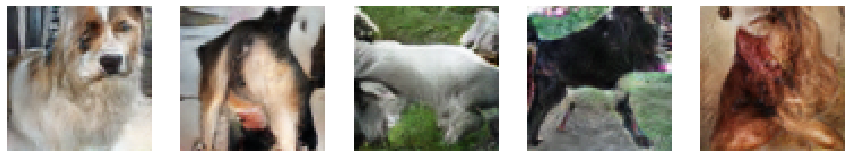

Epoch 121/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.457     gen_loss=60.776     t=56s
Epoch 122/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.461     gen_loss=62.693     t=56s
Epoch 123/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.454     gen_loss=62.333     t=56s
Epoch 124/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.450     gen_loss=63.541     t=56s
Epoch 125/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.462     gen_loss=64.999     t=56s
Epoch 126/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.463     gen_loss=66.648     t=56s
Epoch 127/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.992     gen_loss=26.581     t=56s
Epoch 128/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.518     gen_loss=51.625     t=56s
Epoch 129/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.450     gen_loss=53.002     t=56s
Epoch 130/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.430     gen_loss=54.136     t=56s


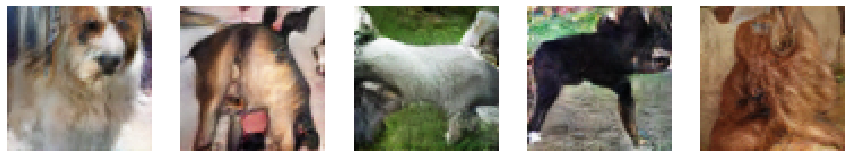

Epoch 131/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.496     gen_loss=55.765     t=56s
Epoch 132/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.445     gen_loss=59.165     t=56s
Epoch 133/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.445     gen_loss=59.172     t=56s
Epoch 134/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.446     gen_loss=60.670     t=56s
Epoch 135/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.451     gen_loss=62.016     t=56s
Epoch 136/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.436     gen_loss=62.355     t=56s
Epoch 137/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.451     gen_loss=64.229     t=56s
Epoch 138/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.481     gen_loss=64.502     t=56s
Epoch 139/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.446     gen_loss=64.370     t=56s
Epoch 140/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.439     gen_loss=64.859     t=56s


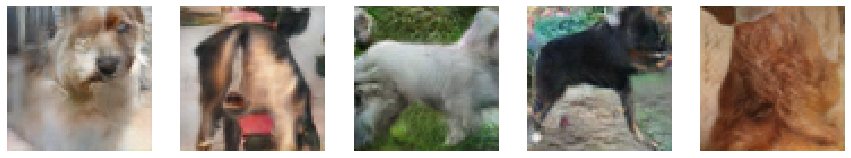

Epoch 141/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.439     gen_loss=65.159     t=56s
Epoch 142/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.455     gen_loss=67.075     t=56s
Epoch 143/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.459     gen_loss=66.783     t=56s
Epoch 144/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.447     gen_loss=65.887     t=56s
Epoch 145/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.444     gen_loss=66.161     t=56s
Epoch 146/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.442     gen_loss=65.809     t=56s
Epoch 147/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.452     gen_loss=67.464     t=56s
Epoch 148/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.449     gen_loss=67.365     t=56s
Epoch 149/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.432     gen_loss=67.476     t=56s
Epoch 150/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.432     gen_loss=69.050     t=56s

 -> MiFID at epoch 

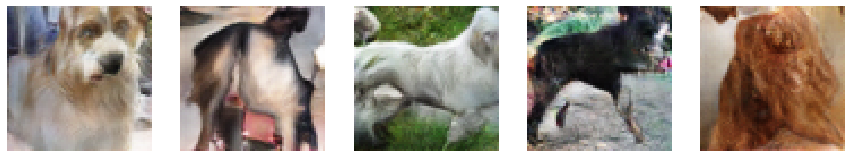

Epoch 161/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.448     gen_loss=70.044     t=56s
Epoch 162/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.433     gen_loss=69.651     t=56s
Epoch 163/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.432     gen_loss=69.315     t=56s
Epoch 164/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.435     gen_loss=71.320     t=56s
Epoch 165/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.427     gen_loss=70.442     t=56s
Epoch 166/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.430     gen_loss=69.432     t=56s
Epoch 167/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.453     gen_loss=68.436     t=56s
Epoch 168/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.420     gen_loss=66.596     t=56s
Epoch 169/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.425     gen_loss=68.368     t=56s
Epoch 170/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.424     gen_loss=69.322     t=56s


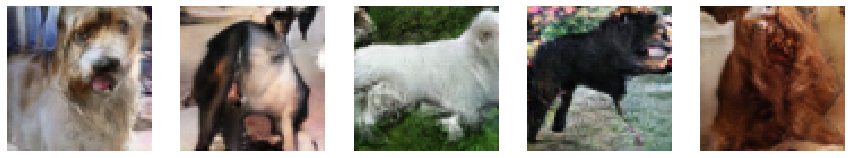

Epoch 171/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.431     gen_loss=69.935     t=56s
Epoch 172/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=67.708     t=56s
Epoch 173/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.433     gen_loss=70.511     t=56s
Epoch 174/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.434     gen_loss=71.398     t=56s
Epoch 175/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.432     gen_loss=71.038     t=56s
Epoch 176/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.429     gen_loss=70.968     t=56s
Epoch 177/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.428     gen_loss=71.383     t=56s
Epoch 178/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.425     gen_loss=71.774     t=56s
Epoch 179/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.424     gen_loss=73.140     t=56s
Epoch 180/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=72.762     t=56s


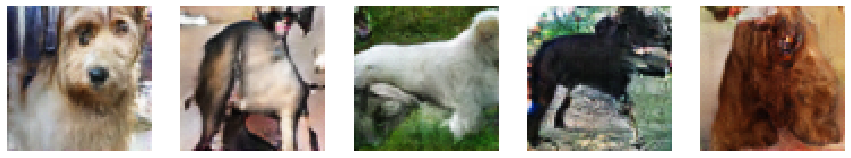

Epoch 181/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.426     gen_loss=71.730     t=56s
Epoch 182/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.431     gen_loss=70.798     t=56s
Epoch 183/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.423     gen_loss=72.730     t=56s
Epoch 184/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=71.202     t=56s
Epoch 185/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.440     gen_loss=72.230     t=56s
Epoch 186/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=68.761     t=56s
Epoch 187/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.419     gen_loss=69.386     t=56s
Epoch 188/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=70.846     t=56s
Epoch 189/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.413     gen_loss=70.913     t=56s
Epoch 190/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.419     gen_loss=71.315     t=56s


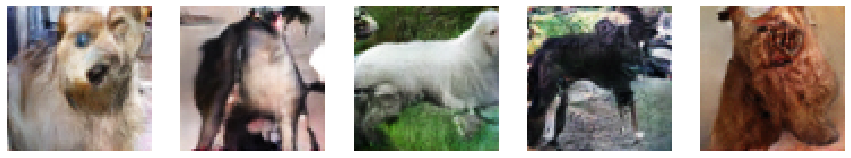

Epoch 191/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.418     gen_loss=70.112     t=56s
Epoch 192/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.425     gen_loss=70.801     t=56s
Epoch 193/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.424     gen_loss=70.412     t=56s
Epoch 194/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.413     gen_loss=67.743     t=56s
Epoch 195/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.412     gen_loss=69.024     t=56s
Epoch 196/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.415     gen_loss=68.290     t=56s
Epoch 197/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.413     gen_loss=68.482     t=56s
Epoch 198/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.412     gen_loss=68.208     t=56s
Epoch 199/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.628     gen_loss=54.072     t=56s
Epoch 200/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.412     gen_loss=57.624     t=56s

 -> MiFID at epoch 

In [31]:
infos = fit(discriminator, generator, dataset, latent_dim=latent_dim,
            epochs=epochs, batch_size=batch_size,
            lr_g=lr_g, lr_d=lr_d, scheduler=scheduler, n_critic=n_critic, 
            class_loss_weight=class_loss_weight, class_epochs=class_epochs)

### Loss Curves

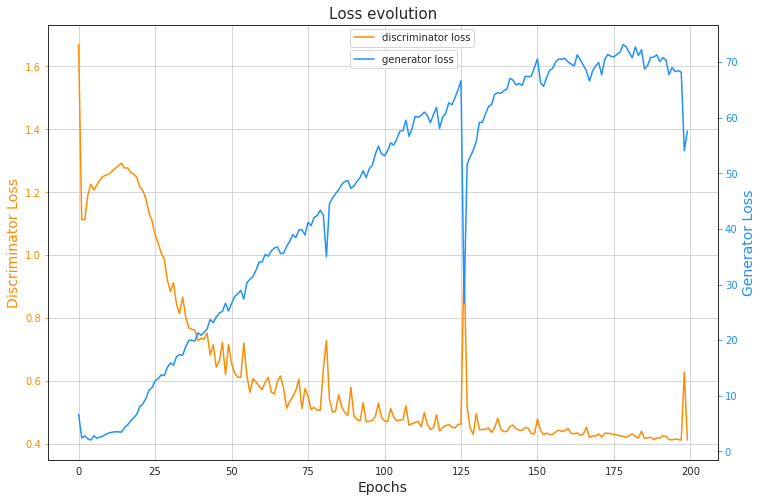

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(infos['discriminator_loss'], label='discriminator loss', c='darkorange')
ax1.set_ylabel('Discriminator Loss', color='darkorange', size=14)
ax1.tick_params(axis='y', colors='darkorange')
ax1.set_xlabel('Epochs', size=14)
plt.grid(True)
plt.legend(loc=(0.45, 0.95))

ax2 = ax1.twinx()
plt.plot(infos['generator_loss'], label='generator loss', c='dodgerblue')
ax2.set_ylabel('Generator Loss', color='dodgerblue', size=14)
ax2.tick_params(axis='y', colors='dodgerblue')
plt.legend(loc=(0.45, 0.9))

plt.title('Loss evolution', size=15)
plt.show()

### Generated Doggos

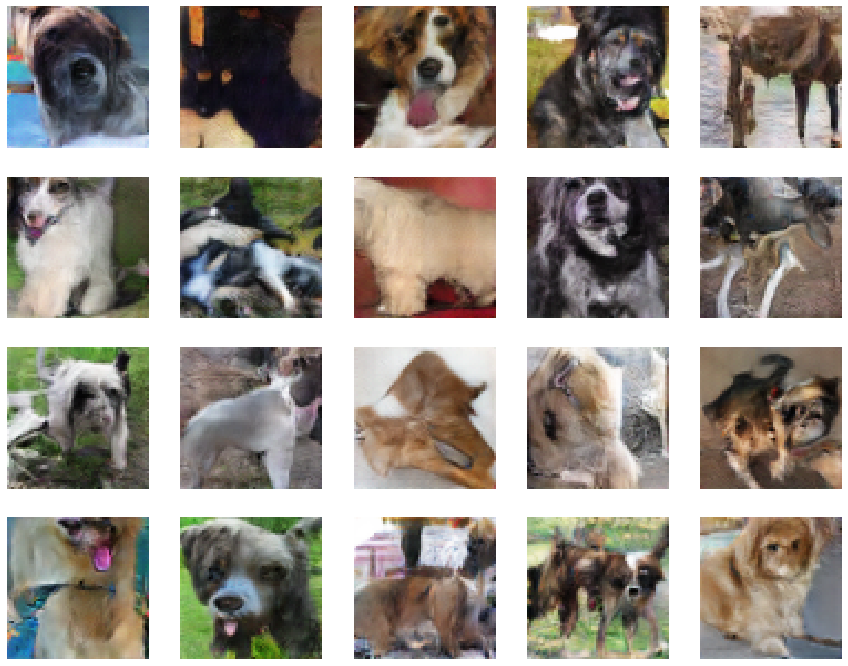

In [33]:
_ = generate(generator, n=20, n_plot=20, latent_dim=latent_dim)

### Latent Walk

In [108]:
save_model_weights(generator, 'cond_gen.pth')
save_model_weights(discriminator, 'cond_dis.pth')


 -> Saving weights to ../output/cond_gen.pth


 -> Saving weights to ../output/cond_dis.pth



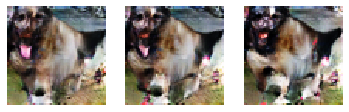

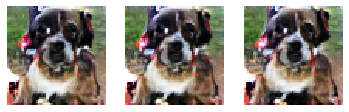

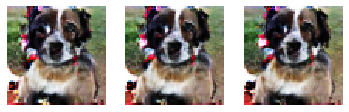

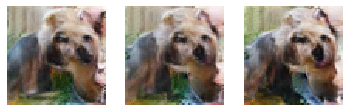

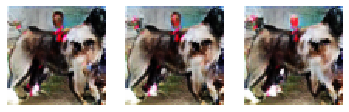

In [104]:
for i in range(5):
    latent_walk(generator, n=2, latent_dim=latent_dim)

In [83]:
print(f"Done in {(time.time() - begin)/60:.1f} minutes")

Done in 315.4 minutes
